In [126]:
import numpy as np
import os, sys
sys.path.insert(0,os.getcwd())
sys.path.insert(0,(os.path.dirname(os.getcwd())))
sys.path.insert(0,os.path.join(os.path.dirname(os.getcwd()), "testing"))
from testing import dnn_dist
from testing.isi_corr import *
from utils.myutil import mtpath_to_expids, exp_id_to_date
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [127]:
# Plot x and y positions of each neuron pair in matches.
test_data_root = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "R_DATA_UnitMatch")
mt_path = os.path.join(test_data_root, "AL036", "19011116882", "3", "new_matchtable.csv")
# mt_path = os.path.join(test_data_root, "AL032", "19011111882", "2", "new_matchtable.csv")
mt = pd.read_csv(mt_path)

In [145]:
rec1, rec2 = 4,5
dnn_metric = "DNNSim"
um_metric = "MatchProb"

mt = mt.loc[(mt["RecSes1"].isin([rec1,rec2])) & (mt["RecSes2"].isin([rec1,rec2])),:]
thresh = dnn_dist.get_threshold(mt, metric=dnn_metric, vis=False)
if um_metric=="MatchProb":
    thresh_um=0.5
else:
    if um_metric=="ScoreExclCentroid":
        col = mt.loc[:, "WavformSim":"LocTrajectorySim"]
        mt[um_metric] = col.mean(axis=1)
    thresh_um = dnn_dist.get_threshold(mt, metric=um_metric, vis=False)
within = mt.loc[(mt["RecSes1"]==mt["RecSes2"]), [dnn_metric, "ISICorr", "ID1", "ID2", um_metric, "RecSes1", "RecSes2"]]
across = mt.loc[(mt["RecSes1"]!=mt["RecSes2"]), [dnn_metric, "ISICorr", um_metric, "RecSes1", "RecSes2", "ID1", "ID2"]]
# Correct for different median similarities between within- and across-day sets.
diff = np.median(within[dnn_metric]) - np.median(across[dnn_metric])
thresh = thresh - diff
diff_um = np.median(within[um_metric]) - np.median(across[um_metric])
thresh_um = thresh_um - diff_um

# Apply thresholds to generate matches for DNN and UnitMatch respectively
matches_across = across.loc[mt[dnn_metric]>=thresh, ["ISICorr", "RecSes1", "RecSes2", "ID1", "ID2", dnn_metric]]
um_matches = across.loc[mt[um_metric]>=thresh_um, ["ISICorr", "RecSes1", "RecSes2", "ID1", "ID2", um_metric]]

# Only allow a match if it is above threshold when comparing in both directions
matches_across = directional_filter(matches_across)
um_matches = directional_filter(um_matches)
if len(matches_across)==0:
    print("no DNN matches found!")
# Do spatial filtering in DNN
# Remove split units from each set of matches
matches_across = remove_split_units(mt_path, within, matches_across, thresh, "DNNSim")
um_matches = remove_split_units(mt_path, within, um_matches, thresh_um, "MatchProb")

filtered_matches = spatial_filter(mt_path, matches_across, 20, plot_drift=False)


In [138]:
exp_ids, metadata = mtpath_to_expids(mt_path, matches_across)
test_data_root = mt_path[:mt_path.find(metadata["mouse"])]
positions = {}
for recses, exp_id in exp_ids.items():
    fp = os.path.join(test_data_root, metadata["mouse"], metadata["probe"], 
                        metadata["loc"], exp_id, "processed_waveforms")
    pos_dict = read_pos(fp)
    positions[recses] = pd.DataFrame(pos_dict)
corrections = get_corrections(matches_across, positions)

In [129]:
exp_ids, metadata = mtpath_to_expids(mt_path, matches_across)
test_data_root = mt_path[:mt_path.find(metadata["mouse"])]
positions = {}
for recses, exp_id in exp_ids.items():
    fp = os.path.join(test_data_root, metadata["mouse"], metadata["probe"], 
                        metadata["loc"], exp_id, "processed_waveforms")
    pos_dict = read_pos(fp)
    positions[recses] = pd.DataFrame(pos_dict)

In [130]:
def shank_filter(matches, positions):
    drops = []
    for idx, row in matches.iterrows():
        df1 = positions[row["RecSes1"]]
        df2 = positions[row["RecSes2"]]
        pos1=df1.loc[df1["file"]==row["ID1"]]
        pos2=df2.loc[df2["file"]==row["ID2"]]
        if pos1["x"].item() != pos2["x"].item():
            drops.append(idx)
    output = matches.drop(drops)
    return output

shank_filtered = shank_filter(matches_across, positions)

In [157]:
# matches_across.insert(len(matches_across.columns), "x1", '')
# matches_across.insert(len(matches_across.columns), "x2", '')
# matches_across.insert(len(matches_across.columns), "y1", '')
# matches_across.insert(len(matches_across.columns), "y2", '')
# matches_across
# for idx, match in matches_across.iterrows():
#     df1 = positions[match["RecSes1"]]
#     df2 = positions[match["RecSes2"]]
#     pos1=df1.loc[df1["file"]==match["ID1"]]
#     pos2=df2.loc[df2["file"]==match["ID2"]]
#     matches_across.at[idx, "x1"] = pos1["x"].item()
#     matches_across.at[idx, "y1"] = pos1["y"].item()
#     matches_across.at[idx, "x2"] = pos2["x"].item()
#     matches_across.at[idx, "y2"] = pos2["y"].item()

def add_pos(df):
    df.insert(len(df.columns), "x1", '')
    df.insert(len(df.columns), "x2", '')
    df.insert(len(df.columns), "y1", '')
    df.insert(len(df.columns), "y2", '')
    for idx, match in df.iterrows():
        df1 = positions[match["RecSes1"]]
        df2 = positions[match["RecSes2"]]
        pos1=df1.loc[df1["file"]==match["ID1"]]
        pos2=df2.loc[df2["file"]==match["ID2"]]
        df.at[idx, "x1"] = pos1["x"].item()
        df.at[idx, "y1"] = pos1["y"].item()
        df.at[idx, "x2"] = pos2["x"].item()
        df.at[idx, "y2"] = pos2["y"].item()
    return df

def add_dc_pos(df):
    'Adds drift corrected positions rather than raw positions.'
    df.insert(len(df.columns), "y2dc", '')
    for idx, match in df.iterrows():
        df1 = positions[match["RecSes1"]]
        df2 = positions[match["RecSes2"]]
        pos1=df1.loc[df1["file"]==match["ID1"]]
        pos2=df2.loc[df2["file"]==match["ID2"]]
        correction = corrections.loc[(corrections["rec1"]==match["RecSes1"]) & (corrections["rec2"]==match["RecSes2"]) 
                                     & (corrections["shank"]==round(match["x1"], -2)), "ydiff"]
        df.at[idx, "y2dc"] = pos2["y"].item() - correction.item()
    return df
# across_samples = across.sample(10)


# for idx, match in across_samples.iterrows():
#     df1 = positions[match["RecSes1"]]
#     df2 = positions[match["RecSes2"]]
#     pos1=df1.loc[df1["file"]==match["ID1"]]
#     pos2=df2.loc[df2["file"]==match["ID2"]]
#     across_samples.at[idx, "x1"] = pos1["x"].item()
#     across_samples.at[idx, "y1"] = pos1["y"].item()
#     across_samples.at[idx, "x2"] = pos2["x"].item()
#     across_samples.at[idx, "y2"] = pos2["y"].item()

# no_dc.insert(len(no_dc.columns), "x1", '')
# no_dc.insert(len(no_dc.columns), "x2", '')
# no_dc.insert(len(no_dc.columns), "y1", '')
# no_dc.insert(len(no_dc.columns), "y2", '')

# for idx, match in no_dc.iterrows():
#     df1 = positions[match["RecSes1"]]
#     df2 = positions[match["RecSes2"]]
#     pos1=df1.loc[df1["file"]==match["ID1"]]
#     pos2=df2.loc[df2["file"]==match["ID2"]]
#     no_dc.at[idx, "x1"] = pos1["x"].item()
#     no_dc.at[idx, "y1"] = pos1["y"].item()
#     no_dc.at[idx, "x2"] = pos2["x"].item()
#     no_dc.at[idx, "y2"] = pos2["y"].item()

# filtered_matches = add_pos(filtered_matches)
# shank_filtered = add_pos(shank_filtered)
# filtered_matches = add_dc_pos(filtered_matches)
# matches_across = add_pos(matches_across)
# matches_across = add_dc_pos(matches_across)

# Just to add the distance column to these ones to check APDs
# matches_across = spatial_filter(mt_path, matches_across, 1e10, False, False)
shank_filtered = spatial_filter(mt_path, shank_filtered, 1e10, False, False)

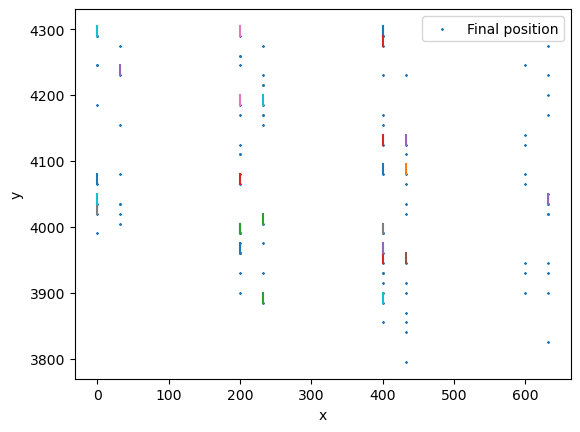

In [159]:
one_way = filtered_matches.loc[(filtered_matches["RecSes1"]==rec1) & (filtered_matches["RecSes2"]==rec2)]
one_way_no_spatial = matches_across.loc[(matches_across["RecSes1"]==rec1) & (matches_across["RecSes2"]==rec2)]
shank_filtered_one_way = shank_filtered.loc[(shank_filtered["RecSes1"]==rec1) & (shank_filtered["RecSes2"]==rec2)]
for idx, row in one_way.iterrows():
    plt.plot([row["x1"], row["x2"]], [row["y1"], row["y2dc"]])
# for idx, row in across_samples.iterrows():
#     plt.plot([row["x1"], row["x2"]], [row["y1"], row["y2"]])
plt.scatter(one_way["x2"], one_way["y2dc"], s=1, label="Final position", marker='*')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


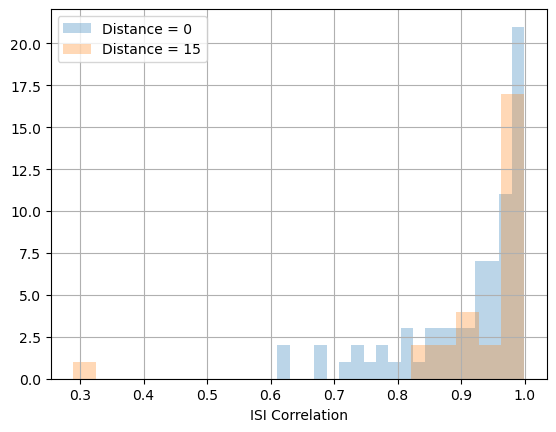

In [167]:
d0 = one_way.loc[one_way["dist"]==0]
d15 = one_way.loc[one_way["dist"]==15]

plt.hist(d0["ISICorr"], alpha=0.3, bins=20, label="Distance = 0")
plt.hist(d15["ISICorr"], alpha=0.3, bins=20, label="Distance = 15")
plt.legend()
plt.xlabel("ISI Correlation")
plt.grid()


In [166]:
def conflicts(matches):
    conflicts = []
    for idx, match in matches.iterrows():
        id1 = match["ID1"]
        id2 = match["ID2"]
        r1 = match["RecSes1"]
        r2 = match["RecSes2"]

        neuron1=matches.loc[(matches["ID1"]==id1) & (matches["RecSes1"]==r1),:]
        if len(neuron1)>1:
            conflicts.append((r1,id1,r2,id2))
        
        neuron2=matches.loc[(matches["ID2"]==id2) & (matches["RecSes2"]==r2),:]
        if len(neuron2)>1:
            conflicts.append((r1,id1,r2,id2))
    return set(conflicts)

conflicts = conflicts(one_way)